# Creating a basic neural network with Tensorflow v1.15

This notebook is inspired by some code available in the [Coursera Deep Learning Specialization]() and has the goal to reproduce the same logic as [Tensorflow playground](https://playground.tensorflow.org/) but in Python.

So in summary you'll be able to choose the following hyperparameters :
- number of hidden layers
- number of units in each layers
- loss function
- activation per layer
- regularization (with rate)
- learning rate

## Import packages

In [124]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## Prepare data

In [3]:
target = 'SalePrice'
cols_to_keep = ['LotArea', 'TotalBsmtSF'] + [target]

In [4]:
train_df = train[cols_to_keep].fillna(0)

## split train test

In [9]:
X, y = train_df.drop(columns=target), train_df[target]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Create NN

### Initialize Weight and bias

In [30]:
def initialize_parameters(n_units, n_features, n_units_output=1):    
    """Initialize parameters Weight and bias and stored them
    in a dictionnary following this format : {'Wl': tf.Variable, 'bl': tf.Variable, ...}.
    
    Where `l` is the layer number. 
    
    The dictionnary also store number of layers L (output layer include)
    
    Parameters
    ----------
    n_units: list
        list of number of units per layer
    n_features: int
        number of features at input layer
    n_units_output: int (default 1)
        number of units at output layer
        
    Returns
    -------
    dict:
        Dictionnary of parameters    
    """
    tf.set_random_seed(1) 
    parameters = {}

    n_units += [n_units_output]    
    n_layers = len(n_units)
    
    parameters['L'] = n_layers
    
    for l in range(0,n_layers):
        num_units = n_units[l]   
        W = f'W{l}'
        b = f'b{l}'

        prev_n_units = n_features if l == 0 else n_units[l-1]

        # Using Xavier initializer for Weight 
        # Todo custom
        parameters[W] = tf.get_variable(name=W, shape=[prev_n_units, num_units], 
                                        initializer = tf.contrib.layers.xavier_initializer())
        # Using zeros initializer for bias
        parameters[b] = tf.get_variable(name=b, shape=[1,num_units], 
                                        initializer = tf.zeros_initializer())

    return parameters

In [31]:
# Test for a NN with 2 hidden layers, 20 features and 2 output units
tf.reset_default_graph()   

initialize_parameters(n_units=[10,5], n_features=20, n_units_output=2)

{'L': 3,
 'W0': <tf.Variable 'W0:0' shape=(20, 10) dtype=float32_ref>,
 'b0': <tf.Variable 'b0:0' shape=(1, 10) dtype=float32_ref>,
 'W1': <tf.Variable 'W1:0' shape=(10, 5) dtype=float32_ref>,
 'b1': <tf.Variable 'b1:0' shape=(1, 5) dtype=float32_ref>,
 'W2': <tf.Variable 'W2:0' shape=(5, 2) dtype=float32_ref>,
 'b2': <tf.Variable 'b2:0' shape=(1, 2) dtype=float32_ref>}

### Compute forward propagation

In [41]:
def compute_layer(A, parameters, layer, activation='relu'):
    """Compute calculus for a given layer
    
    Follow this formula : Z_l = A_{l-1} * W_l + b_l
    
    if activation is set then this function returns : 
    A_l = activation_function(Z_l) 
    
    Where :
    - A is (1, nb units prev layer)
    - W is (nb units prev layer, nb units current layer)
    - b is (1, nb units current layer)
    
    Parameters
    ----------
    A: tf.Variable
        output of the previous layer
    parameters: dict
        Dictionnary of parameters  
    layer: int
        number of the current layer
    activation: str (default relu)
        activation function, if None then just 
        compute the linear calculus
        
    Returns
    -------
    tf.Variable
        Output of the layer calculus
    """
    W = parameters['W'+str(layer)]
    b = parameters['b'+str(layer)]
    
    Z = tf.add(tf.matmul(A,W), b, name=f'Z{layer}')
    
    if activation is not None:
        return tf.nn.relu(Z, name=f'A{layer}') 
    
    return Z

def forward_propagation(X, parameters, activation='relu'):
    """Compute forward propagation given input X and
    initialized parameters.
    
    You can custom activation functionfor the hidden layers
    
    Parameters
    ----------
    X: tf.Variable
        input data shape (n_rows, n_features) 
    parameters: dict
        Dictionnary of parameters  
    activation: str (default relu)
        activation function for hidden layers
        
    Returns
    -------
    tf.Variable
        Prediction output shape (n_rows, n_units_output)
    """
    A = X
    n_layers = parameters['L']
    
    for l in range(0, n_layers):
        act_l = activation if l != n_layers-1 else None
        
        A = compute_layer(A, parameters, layer=l, activation=act_l)
    
    return A

In [42]:
# Test for a NN with 2 hidden layers, 20 features and 2 output units
tf.reset_default_graph()   

parameters = initialize_parameters(n_units=[10,5], n_features=20, n_units_output=2)

X = tf.placeholder(tf.float32, shape=(None, 20), name='X')

forward_propagation(X, parameters, activation='relu')

<tf.Tensor 'Z2:0' shape=(?, 2) dtype=float32>

### Compute cost

Handle the following cost function :

-----

- `MSE`: Mean square Error (or Quadratic Loss or L2 Loss)

$MSE = \frac{1}{n}\sum_{i=1}^{n}{(y_i - \hat{y_i})^2}$

```python
def loss(Y_pred, Y_real):
    return tf.reduce_mean(tf.square(Y_pred - Y_real))
```

-----
- `RMSE`: Root Mean square Error 

$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(y_i - \hat{y_i})^2}}$

```python
def loss(Y_pred, Y_real):
    return tf.sqrt(tf.reduce_mean(tf.square(Y_pred - Y_real)))
```
-----
- `RMSE log`: Root Mean square Error (log values)

$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(\log{y_i} - \log{\hat{y_i}})^2}}$

```python
def loss(Y_pred, Y_real):
    return tf.reduce_mean(tf.abs(Y_pred - Y_real))
```

-----
- `MAE`: Mean Absolute Error (or L1 Loss)

$MAE = \frac{1}{n} \sum_{i=1}^{n}{|y_i - \hat{y_i}|}$

```python
def loss(Y_pred, Y_real):
    return tf.reduce_mean(tf.abs(Y_pred - Y_real))
```

-----
- `Entropy`: Cross Entropy Loss (or Negative Log Likelihood)

$\text{Cross Entropy Loss} = - (y_i\log{\hat{y_i}} + (1-y_i)\log{1-\hat{y_i}})$

```python
def loss(Y_pred, Y_real):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels, logits))

```

In [95]:
def compute_loss(Y_pred, Y_real, loss='RMSE'):
    """Compute loss given a loss function
    
    Loss available : 
    - MSE
    - RMSE
    - RMSE log
    - MAE
    - Entropy
    
    Parameters
    ----------
    Y_pred: tf.Variable
        Predictions from the model
    Y_real: tf.Variable
        Real output
    loss: str (default RMSE)
        loss function to compute
        
    Returns
    -------
    tf.Variable:
        Loss of the model
    """
    if loss == 'MSE':
        return tf.reduce_mean(tf.square(Y_pred - Y_real), name='loss')
    
    elif loss == 'RMSE':
        return tf.sqrt(tf.reduce_mean(tf.square(Y_pred - Y_real)), name='loss')
    
    elif loss == 'RMSE log':
        return tf.reduce_mean(tf.abs(tf.log(Y_pred) - tf.log(Y_real)), name='loss')
        
    elif loss == 'MAE':
        return tf.reduce_mean(tf.abs(Y_pred - Y_real), name='loss')
    
    elif loss == 'Entropy':
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(Y_real, Y_pred), name='loss')
    
    return None


In [96]:
# Test
tf.reset_default_graph()   

parameters = initialize_parameters(n_units=[10], n_features=5)

X = tf.placeholder(tf.float32, shape=(None, 5), name='X')
Y = tf.placeholder(tf.float32, shape=(None, 1), name='Y')

Y_pred = forward_propagation(X, parameters, activation='relu')

In [97]:
compute_loss(Y_pred=Y_pred, Y_real=Y, loss='MSE')

<tf.Tensor 'loss:0' shape=() dtype=float32>

In [98]:
compute_loss(Y_pred=Y_pred, Y_real=Y, loss='RMSE')

<tf.Tensor 'loss_1:0' shape=() dtype=float32>

In [99]:
compute_loss(Y_pred=Y_pred, Y_real=Y, loss='RMSE log')

<tf.Tensor 'loss_2:0' shape=() dtype=float32>

In [100]:
compute_loss(Y_pred=Y_pred, Y_real=Y, loss='MAE')

<tf.Tensor 'loss_3:0' shape=() dtype=float32>

In [101]:
compute_loss(Y_pred=Y_pred, Y_real=Y, loss='Entropy')

<tf.Tensor 'loss_4:0' shape=() dtype=float32>

### Optimizer selection

This the list of possible optimizer to train the neural network :

- GradientDescent: [`tf.train.GradientDescentOptimizer`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/train/GradientDescentOptimizer)
- Momentum: [`tf.train.MomentumOptimizer`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/train/MomentumOptimizer)
- Adagrad: [`tf.train.AdagradOptimizer`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/train/AdagradOptimizer)
- Adadelta: [`tf.train.AdadeltaOptimizer`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/train/AdadeltaOptimizer)
- RMSProp: [`tf.train.RMSPropOptimizer`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/train/RMSPropOptimizer)
- Adam: [`tf.train.AdamOptimizer`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/train/AdamOptimizer)

In [89]:
def select_optimizer(optimizer='GradientDescent'):
    """Select the optimizer
    
    Available optimizers:
    - GradientDescent
    - Momentum
    - Adagrad
    - Adadelta
    - RMSProp
    - Adam
    
    Parameters
    ----------
    optimizer: str (default GradientDescent)
        optimizer to select
        
    Returns
    -------
    tf.train.Optimizer
        Optimizer object
    """
    if optimizer == 'GradientDescent':
        return tf.train.GradientDescentOptimizer
    elif optimizer == 'Momentum':
        return tf.train.MomentumOptimizer
    elif optimizer == 'Adagrad':
        return tf.train.AdagradOptimizer
    elif optimizer == 'Adadelta':
        return tf.train.AdadeltaOptimizer
    elif optimizer == 'RMSProp':
        return tf.train.RMSPropOptimizer
    elif optimizer == 'Adam':
        return tf.train.AdamOptimizer
    
    raise ValueError('Optimizer choosen not available please select a valid one')
    
    return None

In [90]:
select_optimizer(optimizer='Adam')

tensorflow.python.training.adam.AdamOptimizer

### Tensorboard function

In [ ]:
def create_tensorboard(sess, L, grads_and_vars, loss, name='dashboard'):
    """
    """
    if not os.path.exists('summaries'):
        os.mkdir('summaries')
    if not os.path.exists(os.path.join('summaries',name)):
        os.mkdir(os.path.join('summaries',name))

    summ_writer = tf.summary.FileWriter(os.path.join('summaries',name), sess.graph)    
    
    # tf_loss_summary :     you feed in a value by means of a placeholder, 
    #                       whenever you need to publish this to the board
    with tf.name_scope('performance'):
        tf_loss_ph = tf.placeholder(tf.float32,shape=None,name='loss_summary')
        tf_loss_summary = tf.summary.scalar('loss', tf_loss_ph)

        
    # tf_gradnorm_summary : this calculates the l2 norm of the gradients 
    #                       of the last layer of your neural network. 
    #                       Gradient norm is a good indicator of whether the weights 
    #                       of the neural network are being properly updated. 
    #                       A too small gradient norm can indicate vanishing gradient 
    #                       or a too large gradient can imply exploding gradient phenomenon.
    for g, v in grads_and_vars:
        if f'W{L-1}' in v.name:
            with tf.name_scope('gradients'):
                tf_last_grad_norm = tf.sqrt(tf.reduce_mean(g**2))
                tf_gradnorm_summary = tf.summary.scalar('grad_norm', tf_last_grad_norm)
                break
                
    performance_summaries = tf.summary.merge([tf_loss_summary])    
    
    return {
        'writer': summ_writer, 
        'loss': tf_loss_ph, 
        'gradnorm': tf_gradnorm_summary,
        'perf': performance_summaries
    }

### Generate NN with optimizer for back propagation

In [155]:
def plot_cost(train_costs, test_costs=None):
    """Plot the cost every 5 epochs
    """
    plt.plot(np.squeeze(train_costs), label='train')
    if test_costs is not None:
        plt.plot(np.squeeze(test_costs), label='test')
    plt.ylabel('cost')
    plt.xlabel('iterations (per fives)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.legend(loc="upper right")
    plt.show()
    

def fit(feed_dict_train, parameters, optimizer, grads_and_vars, loss, num_epochs,
        epsilon, feed_dict_test, batch_size=None):
    """
    """
    # TODO : implement batch size
    
    init = tf.global_variables_initializer()
    train_costs = list()
    test_costs = list()
    num_epochs = 100000000 if num_epochs is None else num_epochs
    L = parameters['L']
    
    with tf.Session() as sess:
        sess.run(init)
        
        board = create_tensorboard(sess, L, grads_and_vars, loss, name='dashboard')
        summ_writer = board['writer']
        tf_loss_ph = board['loss']
        tf_gradnorm_summary = board['gradnorm']
        performance_summaries = board['perf']
        
        for epoch in range(num_epochs):
            sess.run(optimizer, feed_dict=feed_dict_train)
            
            epoch_l_train, gn_summ = sess.run([loss, tf_gradnorm_summary], feed_dict=feed_dict_train)
            epoch_l_test = sess.run(loss, feed_dict=feed_dict_test)
            
            summ = sess.run(performance_summaries, feed_dict={tf_loss_ph: epoch_l_train})
            
            summ_writer.add_summary(gn_summ, epoch)
            summ_writer.add_summary(summ, epoch)

            if epoch % display_freq == 0:
                print ("At epoch %i, train cost is: %f and test cost is: %f" % (
                    epoch, epoch_l_train, epoch_l_test))
            if epoch % 5 == 0:
                train_costs.append(epoch_l_train)
                test_costs.append(epoch_l_test)
                
                # Early stopping
                if len(train_costs) > 2:
                    if train_costs[-2] - train_costs[-1] < epsilon:
                        print('Stop at epoch %i.'% (epoch))
                        break
                
        # Plot the cost
        plot_cost(train_costs, test_costs)
                
        # lets save the parameters in a variable
        del parameters['L']
        parameters = sess.run(parameters)
        print("Parameters have been trained!")
    
    sess.close()
    return parameters

def neural_network(X_train, Y_train, X_test=None, Y_test=None,
                   learning_rate=0.01, num_epochs=None, epsilon=0.0001, 
                   n_units=[1], activation='relu', loss_fn='RMSE', 
                   optimizer_name='Adam', display_freq=100):
    """
    
    Parameters
    ----------
    X_train: 2 dimensions array like 
        array shape (n_rows, n_features)
    Y_train: array like
        array shape (n_rows, 1)
    X_test: 2 dimensions array like (optional)
        array shape (n_rows, n_features)
    Y_test: array like (optional)
        array shape (n_rows, 1)
    learning_rate: float
        Learning rate for the model
    num_epochs: int (optional)
        number of epoch to train
        If None then it stop if the cost difference
        is less than epsilon
    epsilon: float (default 0.0001)
        threshold to stop learning
    n_units: list (default [1])
        list of units per layer
    activation: str (default 'relu')
        activation function for hidden layers
    loss_fn: str (default RMSE)
        loss function to compute
    optimizer_name: str (default Adam)
        optimizer to use
    display_freq: int (default 100)
        display frequency to follow the model learning
    
    Returns
    -------
    dict:
        Dictionnary of the trained parameters
    """
    
    if type(X_train) == pd.DataFrame:
        X_train = X_train.values
        Y_train = Y_train.values.reshape(-1,1)
        
    if X_test is not None:
        if type(X_test) == pd.DataFrame:
            X_test = X_test.values
            Y_test = Y_test.values.reshape(-1,1)
    
    # Reset graph
    tf.reset_default_graph()
    # Set seed
    tf.set_random_seed(42)
    
    _, n_features = X_train.shape
    
    # Initialize placeholder    
    X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
    Y = tf.placeholder(tf.float32, shape=(None, 1), name='Y')
    
    # Initialize parameters
    parameters = initialize_parameters(n_units, n_features, n_units_output=1)
    
    # Create forward propagation graphs
    Y_pred = forward_propagation(X, parameters, activation)
    
    # Create loss computation graph
    loss = compute_loss(Y_pred, Y, loss=loss_fn)
    
    # Create Optimizer 
    optimizer_obj = select_optimizer(optimizer_name)(learning_rate)
    grads_and_vars = optimizer_obj.compute_gradients(loss)    
    optimizer = optimizer_obj.minimize(loss)
    
    feed_dict_train = {X: X_train, Y: Y_train}
    feed_dict_test = {X: X_test, Y: Y_test} if X_test is not None else None
    
    parameters = fit(feed_dict_train, parameters, optimizer, grads_and_vars, loss, 
                     num_epochs, epsilon, feed_dict_test)
    
    return parameters
    

### Test the training

At epoch 0, train cost is: 4.325962 and test cost is: 4.346067
At epoch 100, train cost is: 2.435147 and test cost is: 2.456405
At epoch 200, train cost is: 1.530335 and test cost is: 1.545562
At epoch 300, train cost is: 0.883988 and test cost is: 0.908920
At epoch 400, train cost is: 0.467912 and test cost is: 0.513343
At epoch 500, train cost is: 0.356832 and test cost is: 0.402809
At epoch 600, train cost is: 0.346679 and test cost is: 0.388927
Stop at epoch 630.


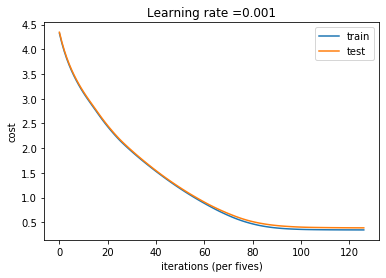

Parameters have been trained!


In [156]:
# Choose hyper parameters
learning_rate = 0.001
num_epochs = None 
epsilon = 0.0001
n_units = [10,10,10]
activation = 'relu' 
loss_fn = 'RMSE log'
optimizer = 'Adam'
# batch_size to implement

# Helper parameters
display_freq = 100

parameters = neural_network(X_train, y_train, X_test, y_test,
                           learning_rate, num_epochs, epsilon, 
                           n_units, activation, loss_fn, optimizer,
                           display_freq)

In [1]:
# !tensorboard --logdir="./summaries/dashboard/" --port 6006

### Re-use trained paramaters to predict

In [ ]:


def predict(X, parameters):
    init = tf.global_variables_initializer()

    X_tf = tf.placeholder(tf.float32, shape=(None, X.shape[1]), name='X')
    Y_pred = forward_propagation(X_tf, parameters)
    
    with tf.Session() as sess:
        sess.run(init)
        
        preds = sess.run(Y_pred, feed_dict={X_tf: X})
                   
    sess.close()
    return preds


def test_model(X_train, Y_train, X_test, Y_test, parameters):
    if type(X_train) == pd.DataFrame:
        X_train = X_train.values
        Y_train = Y_train.values.reshape(-1,1)
        X_test = X_test.values
        Y_test = Y_test.values.reshape(-1,1)    

    pred_train = predict(X_train, parameters)
    pred_test = predict(X_test, parameters)
    
    train_cost = np.sqrt(mean_squared_log_error(Y_train, pred_train ))
    test_cost = np.sqrt(mean_squared_log_error(Y_test, pred_test ))

    print ("Train score:", train_cost)
    print ("Test score:", test_cost)
    

        